In [23]:
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import read_player_stats
import training_data
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn import cross_validation
from sklearn import grid_search
from sklearn import metrics
from sklearn.learning_curve import learning_curve
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.max_columns = 1000

In [7]:
#read in rb data for all seasons
total_df = training_data.make_total_data(seasons=range(2004,2015), pages=[0,1,2,3], pos='wr')

#training samples
train_df = training_data.make_training_df(total_df, seasons=range(2004,2014), ppg=True)

In [8]:
total_df

,Name,Team,Games,Targets,Rec,RecYards,RecTD,RunAtt,RunYards,RunTD,FFP,FFPPG,Season
1389,AJGreen,CIN,15,115,65,1057,7,5,53,0,153.0,10.2,2011
1579,AJGreen,CIN,16,164,97,1350,11,4,38,0,204.8,12.8,2012
1767,AJGreen,CIN,16,178,98,1426,11,0,0,0,208.6,13.0,2013
1961,AJGreen,CIN,12,116,69,1041,6,2,2,0,140.3,11.7,2014
1889,AJJenkins,KC,7,17,8,130,0,2,6,0,13.6,1.9,2013
2088,AJJenkins,KC,7,15,9,93,0,2,-2,0,9.1,1.3,2014
1822,AaronDobson,NE,11,72,37,519,4,0,0,0,75.9,6.9,2013
2107,AaronDobson,NE,4,5,3,38,0,0,0,0,3.8,1.0,2014
162,AaronMoorehead,IND,7,3,1,7,0,0,0,0,0.7,0.1,2004
342,AaronMoorehead,IND,2,11,7,75,0,0,0,0,7.5,3.8,2005


In [9]:
#lets make a function to evaluate the model and make projections for any position

#train on points per game
X_train = np.array(train_df.drop(['Name','FFPPG'], axis=1))
y_train = np.array(train_df['FFPPG'])

In [20]:
#evaluate a linear regression model
parameters = {'alpha': np.logspace(-5,5,num=30)}
lin_model = grid_search.GridSearchCV(linear_model.Ridge(normalize=True), parameters, cv=10)
lin_model.fit(X_train, y_train)

scores =  cross_validation.cross_val_score(lin_model.best_estimator_, X_train, y_train, cv=10, scoring='mean_absolute_error')
scores

array([-2.03534812, -2.15273082, -2.08585182, -2.06206645, -2.09578434,
       -1.91726843, -2.29121429, -2.23794202, -2.0721206 , -2.17700931])

In [25]:
#learning curves
lin_size, lin_train_score, lin_cv_score = learning_curve(lin_model.best_estimator_, X_train, y_train, train_sizes=[5,10,50,100,500], cv=10, scoring='mean_absolute_error')
lin_avg_train = np.mean(lin_train_score, axis=1)
lin_avg_cv = np.mean(lin_cv_score, axis=1)

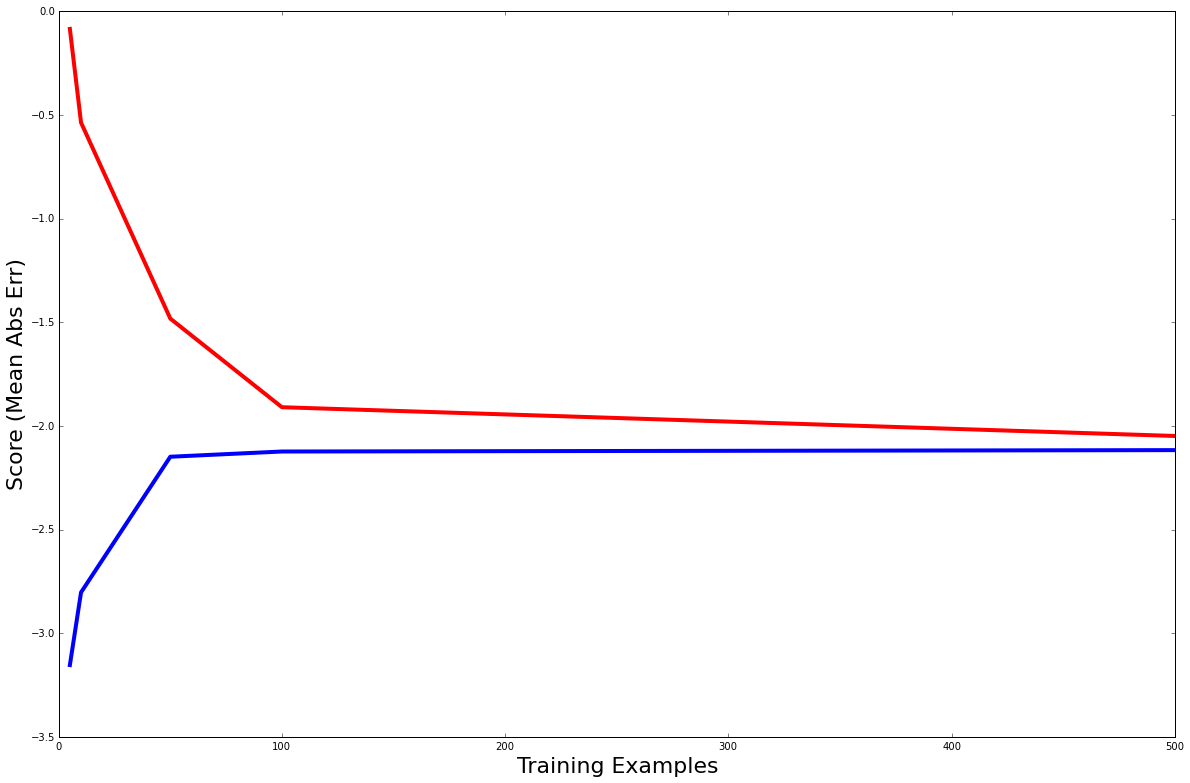

In [26]:
fig = plt.figure(figsize=(20, 13))
plt.xlabel('Training Examples', fontsize=22)
plt.ylabel('Score (Mean Abs Err)', fontsize=22)
plt.plot(lin_size, lin_avg_train, 'r-', label='Linear Reg Train', linewidth=4.0)
plt.plot(lin_size, lin_avg_cv, 'b-', label='Linear Reg CV', linewidth=4.0)

In [29]:
#2015 projections
most_rec_df = training_data.merge_seasons(total_df[total_df.Season == 2013], total_df[total_df.Season == 2014])
most_rec_df.dropna(inplace=True)

In [30]:
most_rec_df

,Name,Games_1,Targets_1,Rec_1,RecYards_1,RecTD_1,RunAtt_1,RunYards_1,RunTD_1,FFP_1,FFPPG_1,Games_2,Targets_2,Rec_2,RecYards_2,RecTD_2,RunAtt_2,RunYards_2,RunTD_2,FFP_2,FFPPG_2
0,AJGreen,16,178,98,1426,11,0,0,0,208.6,13.0,12,116,69,1041,6,2,2,0,140.3,11.7
1,AJJenkins,7,17,8,130,0,2,6,0,13.6,1.9,7,15,9,93,0,2,-2,0,9.1,1.3
2,AaronDobson,11,72,37,519,4,0,0,0,75.9,6.9,4,5,3,38,0,0,0,0,3.8,1.0
3,AceSanders,15,87,51,484,1,3,4,0,54.8,3.7,7,8,6,55,0,0,0,0,5.5,0.8
4,AldrickRobinson,13,46,18,365,2,3,-4,0,48.1,3.7,2,3,1,6,0,0,0,0,0.6,0.3
5,AlshonJeffery,16,149,89,1421,7,16,105,0,194.6,12.2,16,145,85,1133,10,6,33,0,176.6,11.0
6,AndreCaldwell,12,29,16,200,3,1,7,0,38.7,3.2,8,15,5,47,0,0,0,0,4.7,0.6
7,AndreHolmes,10,52,25,431,1,0,0,0,49.1,4.9,15,99,47,693,4,0,0,0,93.3,6.2
8,AndreJohnson,16,181,109,1407,5,0,0,0,170.7,10.7,15,146,85,936,3,0,0,0,111.6,7.4
9,AndreRoberts,16,76,43,471,2,0,0,0,59.1,3.7,16,73,36,453,2,2,21,0,59.4,3.7


In [32]:
model = lin_model.best_estimator_

X_proj = np.array(most_rec_df.drop('Name', axis=1))
y_proj = model.predict(X_proj)

In [34]:
most_rec_df['2015 Projection'] = y_proj
#The projections
most_rec_df[['Name', '2015 Projection']].sort(columns='2015 Projection', ascending=False)

,Name,2015 Projection
12,AntonioBrown,12.678029
47,DemaryiusThomas,12.068404
52,DezBryant,11.689193
86,JordyNelson,11.375867
5,AlshonJeffery,10.395144
141,RandallCobb,10.364489
26,CalvinJohnson,10.086471
93,JulioJones,9.910243
61,EmmanuelSanders,9.782172
0,AJGreen,9.527231
